# Model Re-Training Using Transfer Learning

This notebook implements a comprehensive transfer learning pipeline for **dental/oral pathology classification** using multiple pre-trained models. The dataset contains 7 classes of oral conditions with 5,624 total images.

**Author: Ahmed Mohammad Fayad**

## 🦷 Dataset Overview
- **Total Images**: 5,624
- **Classes**: 7 (MC, OLP, Gum, CoS, OC, CaS, OT)
- **Training**: 3,087 images (97 batches)
- **Validation**: 1,028 images (33 batches)  
- **Test**: 1,508 images (48 batches)

---

## 1. Setup and Imports

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("✅ All imports successful!")

✅ All imports successful!


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

## 2. Loading Data Using Past Pipeline

In [3]:
def load_existing_pipeline():
    """Load your saved pipeline and prepare datasets"""

    # Load the pipeline
    from processing_pipeline import DatasetPipeline
    pipeline = DatasetPipeline()

    # Run the pipeline to get datasets
    train_data, val_data, test_data, stats = pipeline.run()

    print("Pipeline loaded successfully!")
    print(f"Classes: {pipeline.class_names}")
    print(f"Number of classes: {len(pipeline.class_names)}")
    print(f"Training batches: {len(train_data)}")
    print(f"Validation batches: {len(val_data)}")
    print(f"Test batches: {len(test_data)}")

    return train_data, val_data, test_data, pipeline.class_names, stats

Starting Dataset Pipeline...
Google Drive already mounted.
Extracting dataset from /content/drive/MyDrive/Datasets/Teeth DataSet.zip...
Dataset successfully extracted to: /content/drive/MyDrive/Datasets/Extracted Dataset/Teeth_Dataset

DATASET ANALYSIS
Training images: 3087
Validation images: 1028
Test images: 1509
Total images: 5624
Number of classes: 7
Classes: CaS, CoS, Gum, MC, OC, OLP, OT
Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.

TensorFlow datasets created successfully!
Training batches: 97
Validation batches: 33
Test batches: 33

Generating sample visualization...


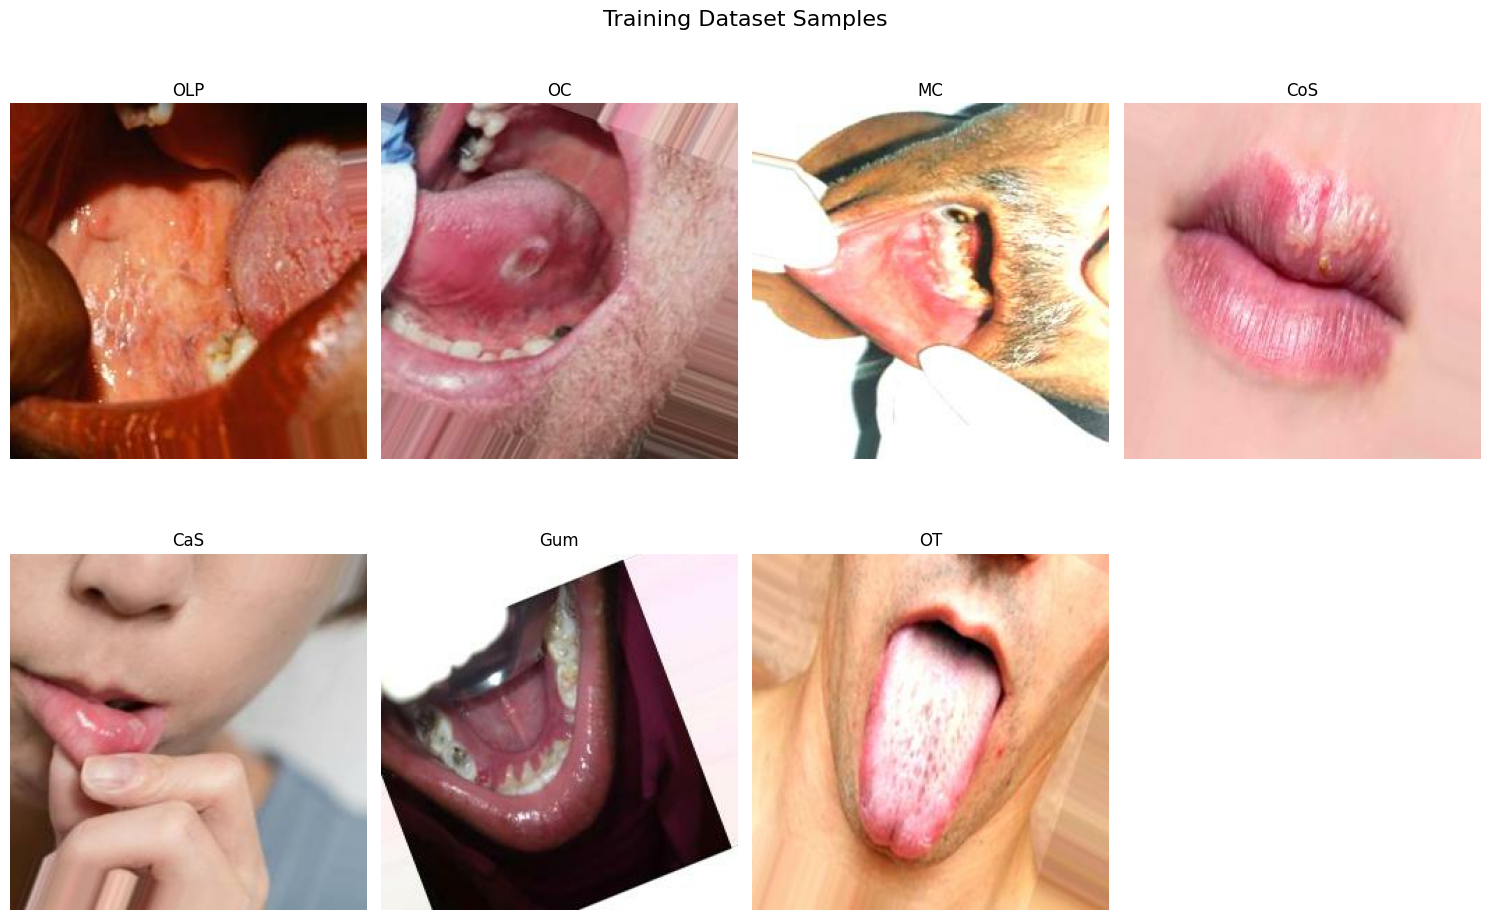


Pipeline completed!
Pipeline loaded successfully!
Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Number of classes: 7
Training batches: 97
Validation batches: 33
Test batches: 33


In [5]:
# Load your existing pipeline and data
train_data, val_data, test_data, class_names, stats = load_existing_pipeline()

In [7]:
print(f"\n📈 Batch Information:")
print(f"- Training batches: {len(train_data)}")
print(f"- Validation batches: {len(val_data)}")
print(f"- Test batches: {len(test_data)}")


📈 Batch Information:
- Training batches: 97
- Validation batches: 33
- Test batches: 33


In [8]:
# Display dataset information
print("\n" + "="*60)
print("📊 DENTAL PATHOLOGY DATASET OVERVIEW")
print("="*60)
print("Dataset: Teeth Classification (Oral Pathology)")
print("Total Images: 5,624")
print("- Training: 3,087 images")
print("- Validation: 1,028 images")
print("- Test: 1,508 images")
print("\n🏷️ Class Information:")
class_descriptions = {
    'MC': 'Mucocele',
    'OLP': 'Oral Lichen Planus',
    'Gum': 'Gum Disease',
    'CoS': 'Canker Sore',
    'OC': 'Oral Cancer',
    'CaS': 'Cold Sore',
    'OT': 'Other/Normal'
}

for i, class_name in enumerate(class_names):
    description = class_descriptions.get(class_name, 'Unknown condition')
    print(f"  {i+1}. {class_name}: {description}")


📊 DENTAL PATHOLOGY DATASET OVERVIEW
Dataset: Teeth Classification (Oral Pathology)
Total Images: 5,624
- Training: 3,087 images
- Validation: 1,028 images
- Test: 1,508 images

🏷️ Class Information:
  1. CaS: Cold Sore
  2. CoS: Canker Sore
  3. Gum: Gum Disease
  4. MC: Mucocele
  5. OC: Oral Cancer
  6. OLP: Oral Lichen Planus
  7. OT: Other/Normal


---

## 3. Transfer Learning Model

In [26]:
def create_transfer_learning_model(input_shape=(256, 256, 3), num_classes=7, base_model_name='EfficientNetB0'):
    """
    Create a transfer learning model with data augmentation for dental pathology classification.

    Args:
        input_shape: Input image shape (height, width, channels), default: (256, 256, 3)
        num_classes: Number of output classes, default: 7
        base_model_name: Pre-trained model ('EfficientNetB0', 'ResNet50'), default: EfficientNetB0

    Returns:
        model: Complete transfer learning model
        base_model: Base pre-trained model for fine-tuning
    """

    # Model selection
    model_dict = {
        'EfficientNetB0': EfficientNetB0,
        'ResNet50': ResNet50
    }

    if base_model_name not in model_dict:
        raise ValueError(f"Unsupported model: {base_model_name}. Choose from {list(model_dict.keys())}")

    # Data augmentation tailored for dental images
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),  # Reduced rotation for dental images
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1)  # Slight shifts
    ])

    # Input layer
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Apply augmentation
    x = data_augmentation(inputs)

    # Resize only for ResNet50 (EfficientNetB0 supports 256x256 natively)
    if base_model_name == 'ResNet50':
        x = tf.keras.layers.Resizing(224, 224)(x)

    # Apply model-specific preprocessing
    if base_model_name == 'EfficientNetB0':
        x = tf.keras.applications.efficientnet.preprocess_input(x)
    else:  # ResNet50
        x = tf.keras.applications.resnet50.preprocess_input(x)

    # Load pre-trained base model
    base_model = model_dict[base_model_name](
        weights='imagenet',
        include_top=False,
        input_tensor=x
    )

    # Freeze base model initially
    base_model.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)  # Reduced size for efficiency
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)  # Adjusted for dataset size
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create complete model
    model = Model(inputs=inputs, outputs=predictions)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall']  # Added for medical dataset
    )

    print(f"✅ {base_model_name} Transfer Learning Model Created!")
    print(f"📊 Total parameters: {model.count_params():,}")
    print(f"🔧 Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
    print("💡 For fine-tuning, unfreeze the top 20% of base_model layers and train with a lower learning rate (e.g., 1e-5).")

    return model, base_model

In [11]:
# Test model creation with your specific dataset
input_shape = (256, 256, 3)
num_classes = len(class_names)  # Should be 7

print(f"🔍 Dataset Configuration:")
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Expected classes: ['MC', 'OLP', 'Gum', 'CoS', 'OC', 'CaS', 'OT']
print(f"\n📊 Dataset Size:")
print(f"Training samples: ~3,087 images")
print(f"Validation samples: ~1,028 images")
print(f"Test samples: ~1,508 images")
print(f"Total: ~5,624 images")

🔍 Dataset Configuration:
Input shape: (256, 256, 3)
Number of classes: 7
Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

📊 Dataset Size:
Training samples: ~3,087 images
Validation samples: ~1,028 images
Test samples: ~1,508 images
Total: ~5,624 images


---

## 4. Training Callbacks

In [27]:
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from datetime import datetime

def get_training_callbacks(model_name, save_path='/content/drive/MyDrive/Models/Teeth Classification/'):
    """Create optimized training callbacks."""
    # Ensure save_path exists
    os.makedirs(save_path, exist_ok=True)

    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=os.path.join(save_path, f'{model_name}_best.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        TensorBoard(
            log_dir=os.path.join(save_path, 'logs', f'{model_name}_{datetime.now().strftime("%Y%m%d_%H%M%S")}'),
            histogram_freq=1,
            write_graph=True,
            write_images=True
        )
    ]

    return callbacks

In [28]:
# Test callbacks creation
test_callbacks = get_training_callbacks('test_model')
print(f"✅ Created {len(test_callbacks)} training callbacks:")
for i, callback in enumerate(test_callbacks):
    print(f"  {i+1}. {callback.__class__.__name__}")

✅ Created 4 training callbacks:
  1. EarlyStopping
  2. ReduceLROnPlateau
  3. ModelCheckpoint
  4. TensorBoard


---

## 5. Training Process

In [29]:
def train_transfer_learning_model(model, base_model, train_data, val_data,
                                 epochs_initial=20, epochs_fine_tune=10,
                                 model_name='transfer_model'):
    """
    Training Process:
      Phase 1: Train custom head with frozen base model
      Phase 2: Fine-tuning with unfrozen layers
    """

    # Phase 1: Train custom head with frozen base model
    print("="*60)
    print("🔥 PHASE 1: TRAINING CUSTOM HEAD (Frozen Base Model)")
    print("="*60)

    base_model.trainable = False
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall']
    )

    callbacks_initial = get_training_callbacks(f'{model_name}_initial')

    history_initial = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs_initial,
        callbacks=callbacks_initial,
        verbose=1
    )

    # Phase 2: Fine-tuning
    print("\n" + "="*60)
    print("🔥 PHASE 2: FINE-TUNING (Unfrozen Layers)")
    print("="*60)

    base_model.trainable = True
    # Fine-tune from top 20% of layers (more conservative for dataset size)
    fine_tune_at = int(len(base_model.layers) * 0.8)  # e.g., ~47 layers for EfficientNetB0

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall']
    )

    print(f"🎯 Fine-tuning from layer {fine_tune_at} onwards")
    print(f"🔧 Trainable layers: {len([l for l in base_model.layers if l.trainable])}")

    callbacks_fine_tune = get_training_callbacks(f'{model_name}_fine_tune')

    history_fine_tune = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs_fine_tune,
        callbacks=callbacks_fine_tune,
        verbose=1
    )

    return history_initial, history_fine_tune

---

## 6. Evaluation and Visualization

In [37]:
def evaluate_transfer_model(model, test_data, class_names, model_name):
    """Comprehensive evaluation of transfer learning model."""

    print(f"\n{'='*50}")
    print(f"📊 EVALUATING {model_name.upper()}")
    print(f"{'='*50}")

    # Test evaluation (expecting loss, accuracy, precision, recall)
    results = model.evaluate(test_data, verbose=0)
    if len(results) != 4:
        raise ValueError(f"Expected 4 metrics (loss, accuracy, precision, recall), got {len(results)}")

    test_loss, test_accuracy, test_precision, test_recall = results
    print(f"📉 Test Loss: {test_loss:.4f}")
    print(f"🎯 Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"📈 Test Precision: {test_precision:.4f}")
    print(f"📈 Test Recall: {test_recall:.4f}")

    # Calculate F1-score
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)
    print(f"📈 Test F1-Score: {test_f1:.4f}")

    # Generate predictions for detailed analysis
    y_true = []
    y_pred = []

    for images, labels in test_data:
        true_labels = np.argmax(labels.numpy(), axis=1)
        predictions = model.predict(images, verbose=0)
        pred_labels = np.argmax(predictions, axis=1)
        y_true.extend(true_labels)
        y_pred.extend(pred_labels)

    # Classification report
    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return test_accuracy

In [16]:
def plot_transfer_learning_history(history1, history2, model_name):
    """Plot training history for both phases"""

    plt.figure(figsize=(15, 10))

    # Combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs = range(1, len(acc) + 1)
    phase1_end = len(history1.history['accuracy'])

    # Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.axvline(x=phase1_end, color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
    plt.title(f'{model_name} - Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.axvline(x=phase1_end, color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
    plt.title(f'{model_name} - Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Phase 1 detailed view
    plt.subplot(2, 2, 3)
    plt.plot(history1.history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(history1.history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.title('Phase 1: Feature Extraction')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Phase 2 detailed view
    plt.subplot(2, 2, 4)
    plt.plot(history2.history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(history2.history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.title('Phase 2: Fine-tuning')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print(f"\n📊 Final Results for {model_name}:")
    print(f"Phase 1 Final Val Accuracy: {history1.history['val_accuracy'][-1]:.4f}")
    print(f"Phase 2 Final Val Accuracy: {history2.history['val_accuracy'][-1]:.4f}")
    print(f"🏆 Best Val Accuracy: {max(val_acc):.4f}")

---

## 7. Train ResNet50 Model


In [41]:
# Create ResNet50 model
print("🚀 Creating ResNet50 Transfer Learning Model...")
resnet_model, resnet_base = create_transfer_learning_model(
    input_shape, num_classes, 'ResNet50'
)

🚀 Creating ResNet50 Transfer Learning Model...
✅ ResNet50 Transfer Learning Model Created!
📊 Total parameters: 24,154,759
🔧 Trainable parameters: 562,695
💡 For fine-tuning, unfreeze the top 20% of base_model layers and train with a lower learning rate (e.g., 1e-5).


In [ ]:
# Display model summary
print("\n📋 Model Summary:")
resnet_model.summary()

In [ ]:
# Train ResNet50 model
print("🔥 Training ResNet50 Model...")
initial_history, fine_tune_history = train_transfer_learning_model(
    resnet_model, resnet_base, train_data, val_data,
    epochs_initial=20, epochs_fine_tune=10,
    model_name='resnet50'
)

🔥 Training ResNet50 Model...
🔥 PHASE 1: TRAINING CUSTOM HEAD (Frozen Base Model)
Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - Precision: 0.8891 - Recall: 0.8500 - accuracy: 0.8666 - loss: 0.3745
Epoch 1: val_accuracy improved from -inf to 0.96401, saving model to /content/drive/MyDrive/Models/Teeth Classification/resnet50_initial_best.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 247ms/step - Precision: 0.8891 - Recall: 0.8500 - accuracy: 0.8666 - loss: 0.3745 - val_Precision: 0.9725 - val_Recall: 0.9621 - val_accuracy: 0.9640 - val_loss: 0.1011 - learning_rate: 0.0010
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - Precision: 0.8994 - Recall: 0.8633 - accuracy: 0.8830 - loss: 0.3548
Epoch 2: val_accuracy improved from 0.96401 to 0.97665, saving model to /content/drive/MyDrive/Models/Teeth Classification/resnet50_initial_best.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 209ms/step - Precision: 0.8994 - Recall: 0.8632 - accuracy: 0.8830 - loss: 0.3547 - val_Precision: 0.9794 - val_Recall:


📊 EVALUATING RESNET50
📉 Test Loss: 0.0408
🎯 Test Accuracy: 98.74%
📈 Test Precision: 0.9883
📈 Test Recall: 0.9854
📈 Test F1-Score: 0.9868

📋 Classification Report:
              precision    recall  f1-score   support

         CaS     0.9875    0.9875    0.9875       160
         CoS     1.0000    1.0000    1.0000       149
         Gum     1.0000    0.9917    0.9958       120
          MC     0.9889    0.9889    0.9889       180
          OC     0.9545    0.9722    0.9633       108
         OLP     0.9832    0.9778    0.9805       180
          OT     0.9924    0.9924    0.9924       131

    accuracy                         0.9874      1028
   macro avg     0.9866    0.9872    0.9869      1028
weighted avg     0.9874    0.9874    0.9874      1028



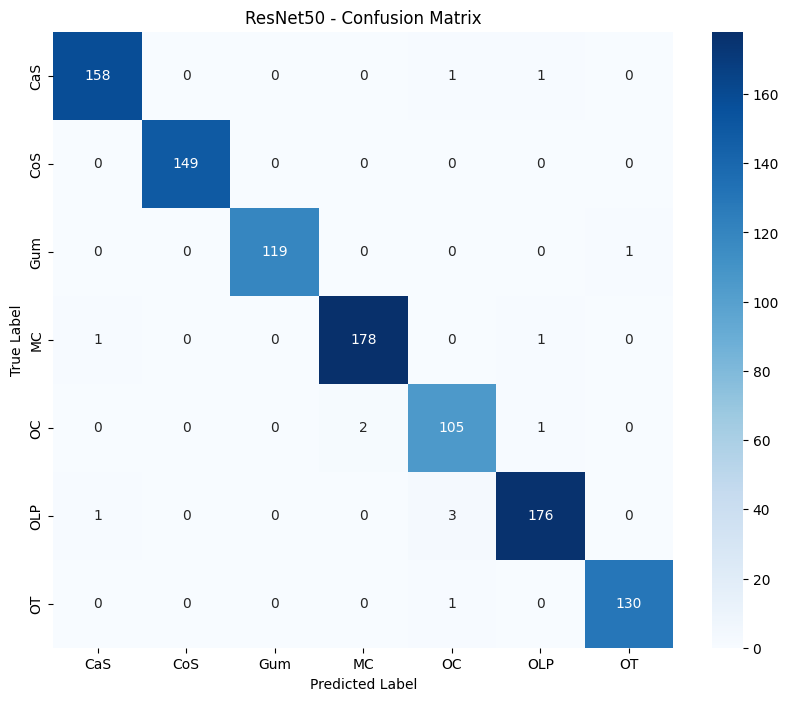

In [ ]:
# Evaluate ResNet50 model
resnet_accuracy = evaluate_transfer_model(
    resnet_model, test_data, class_names, 'ResNet50'
)

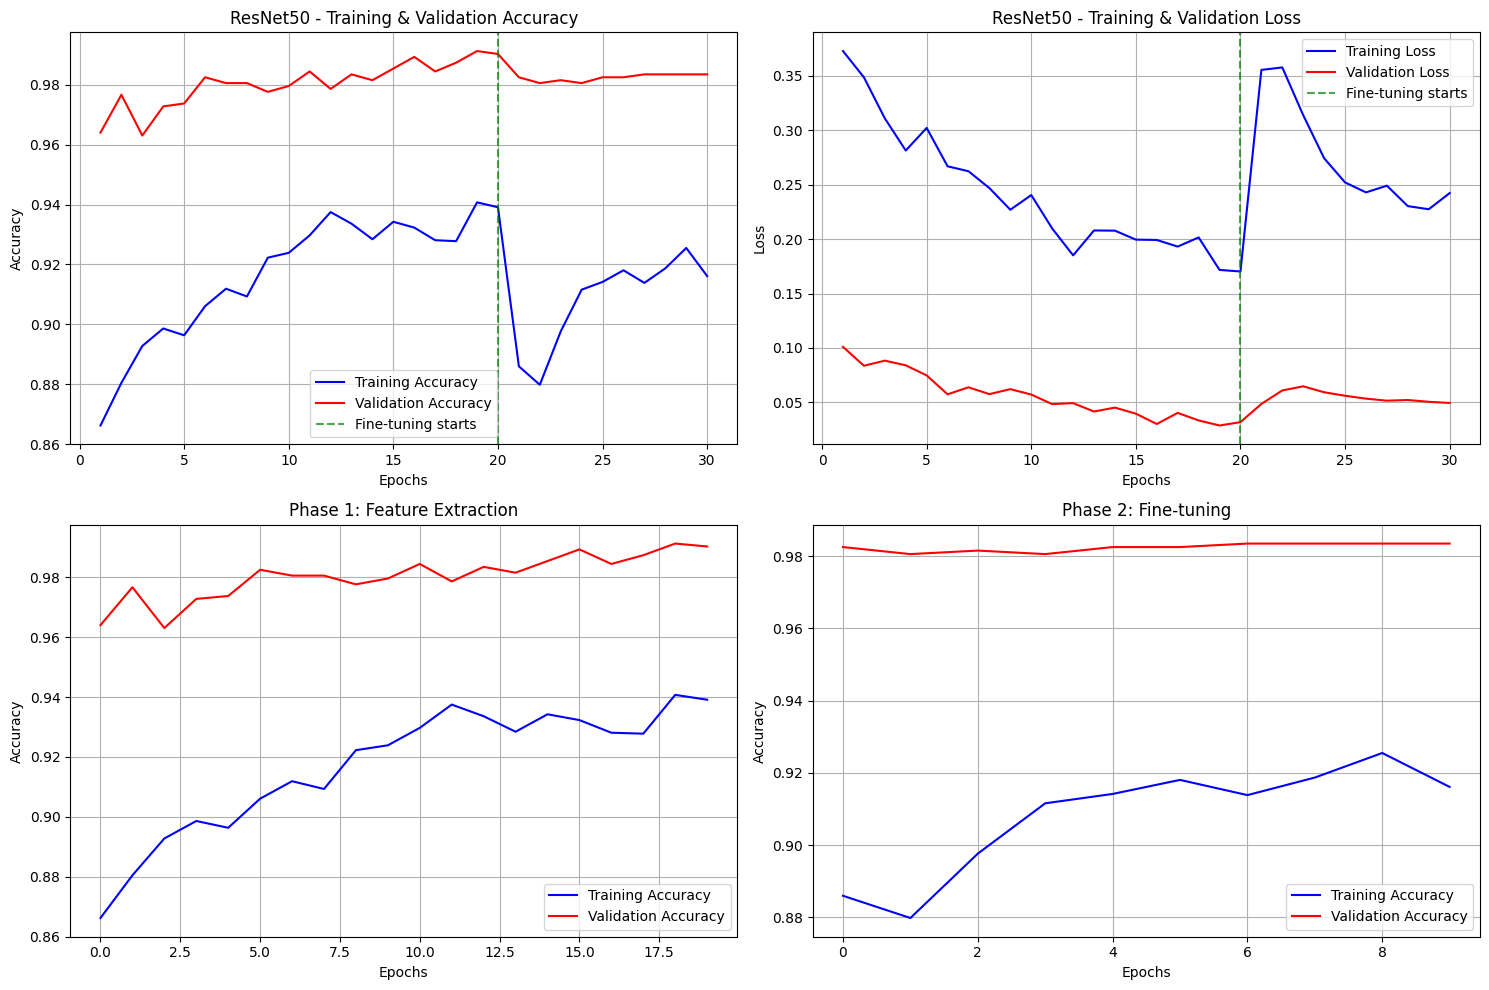


📊 Final Results for ResNet50:
Phase 1 Final Val Accuracy: 0.9903
Phase 2 Final Val Accuracy: 0.9835
🏆 Best Val Accuracy: 0.9912


In [47]:
# Plot training history
plot_transfer_learning_history(initial_history, fine_tune_history, 'ResNet50')

In [48]:
# Save ResNet50 model
resnet_save_path = '/content/drive/MyDrive/Models/Teeth Classification/resnet50_transfer_final.keras'
resnet_model.save(resnet_save_path)
print(f"✅ ResNet50 model saved to: {resnet_save_path}")

✅ ResNet50 model saved to: /content/drive/MyDrive/Models/Teeth Classification/resnet50_transfer_final.keras


---

## 8. Train EfficientNetB0 Model

In [30]:
# Create EfficientNetB0 model
print("🚀 Creating EfficientNetB0 Transfer Learning Model...")
efficientnet_model, efficientnet_base = create_transfer_learning_model(
    input_shape=(256, 256, 3), num_classes=7,
    base_model_name='EfficientNetB0'
    )

🚀 Creating EfficientNetB0 Transfer Learning Model...
✅ EfficientNetB0 Transfer Learning Model Created!
📊 Total parameters: 4,416,938
🔧 Trainable parameters: 364,551
💡 For fine-tuning, unfreeze the top 20% of base_model layers and train with a lower learning rate (e.g., 1e-5).


In [ ]:
# Display model summary
print("\n📋 Model Summary:")
efficientnet_model.summary()

In [33]:
# Train EfficientNetB0 model
print("🔥 Training EfficientNetB0 Model...")
history_initial, history_fine_tune = train_transfer_learning_model(
    efficientnet_model, efficientnet_base, train_data, val_data,
    epochs_initial=20, epochs_fine_tune=10,
    model_name='efficientnetb0'
)

🔥 Training EfficientNetB0 Model...
🔥 PHASE 1: TRAINING CUSTOM HEAD (Frozen Base Model)
Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - Precision: 0.4358 - Recall: 0.2641 - accuracy: 0.3623 - loss: 1.9526
Epoch 1: val_accuracy improved from -inf to 0.66245, saving model to /content/drive/MyDrive/Models/Teeth Classification/efficientnetb0_initial_best.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - Precision: 0.4369 - Recall: 0.2649 - accuracy: 0.3632 - loss: 1.9493 - val_Precision: 0.9403 - val_Recall: 0.3220 - val_accuracy: 0.6625 - val_loss: 1.0510 - learning_rate: 0.0010
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - Precision: 0.6846 - Recall: 0.5035 - accuracy: 0.5995 - loss: 1.1065
Epoch 2: val_accuracy improved from 0.66245 to 0.78794, saving model to /content/drive/MyDrive/Models/Teeth Classification/efficientnetb0_initial_best.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - Precision: 0.6845 - Recall: 0.5035 - accuracy: 0.5995 - loss: 1.1065 - val_Precision: 0.


📊 EVALUATING EFFICIENTNETB0
📉 Test Loss: 0.1349
🎯 Test Accuracy: 95.33%
📈 Test Precision: 0.9578
📈 Test Recall: 0.9504
📈 Test F1-Score: 0.9541

📋 Classification Report:
              precision    recall  f1-score   support

         CaS     0.9865    0.9125    0.9481       160
         CoS     0.9801    0.9933    0.9867       149
         Gum     0.9914    0.9583    0.9746       120
          MC     0.9553    0.9500    0.9526       180
          OC     0.8814    0.9630    0.9204       108
         OLP     0.9135    0.9389    0.9260       180
          OT     0.9695    0.9695    0.9695       131

    accuracy                         0.9533      1028
   macro avg     0.9539    0.9551    0.9540      1028
weighted avg     0.9547    0.9533    0.9535      1028



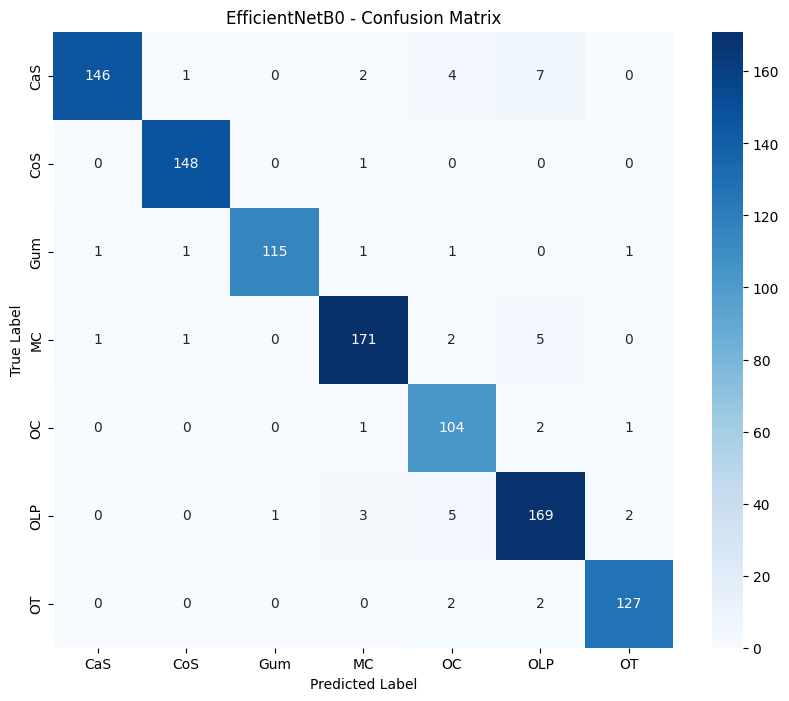

In [38]:
# Evaluate EfficientNetB0 model
efficientnet_accuracy = evaluate_transfer_model(
    efficientnet_model, test_data, class_names, 'EfficientNetB0'
)

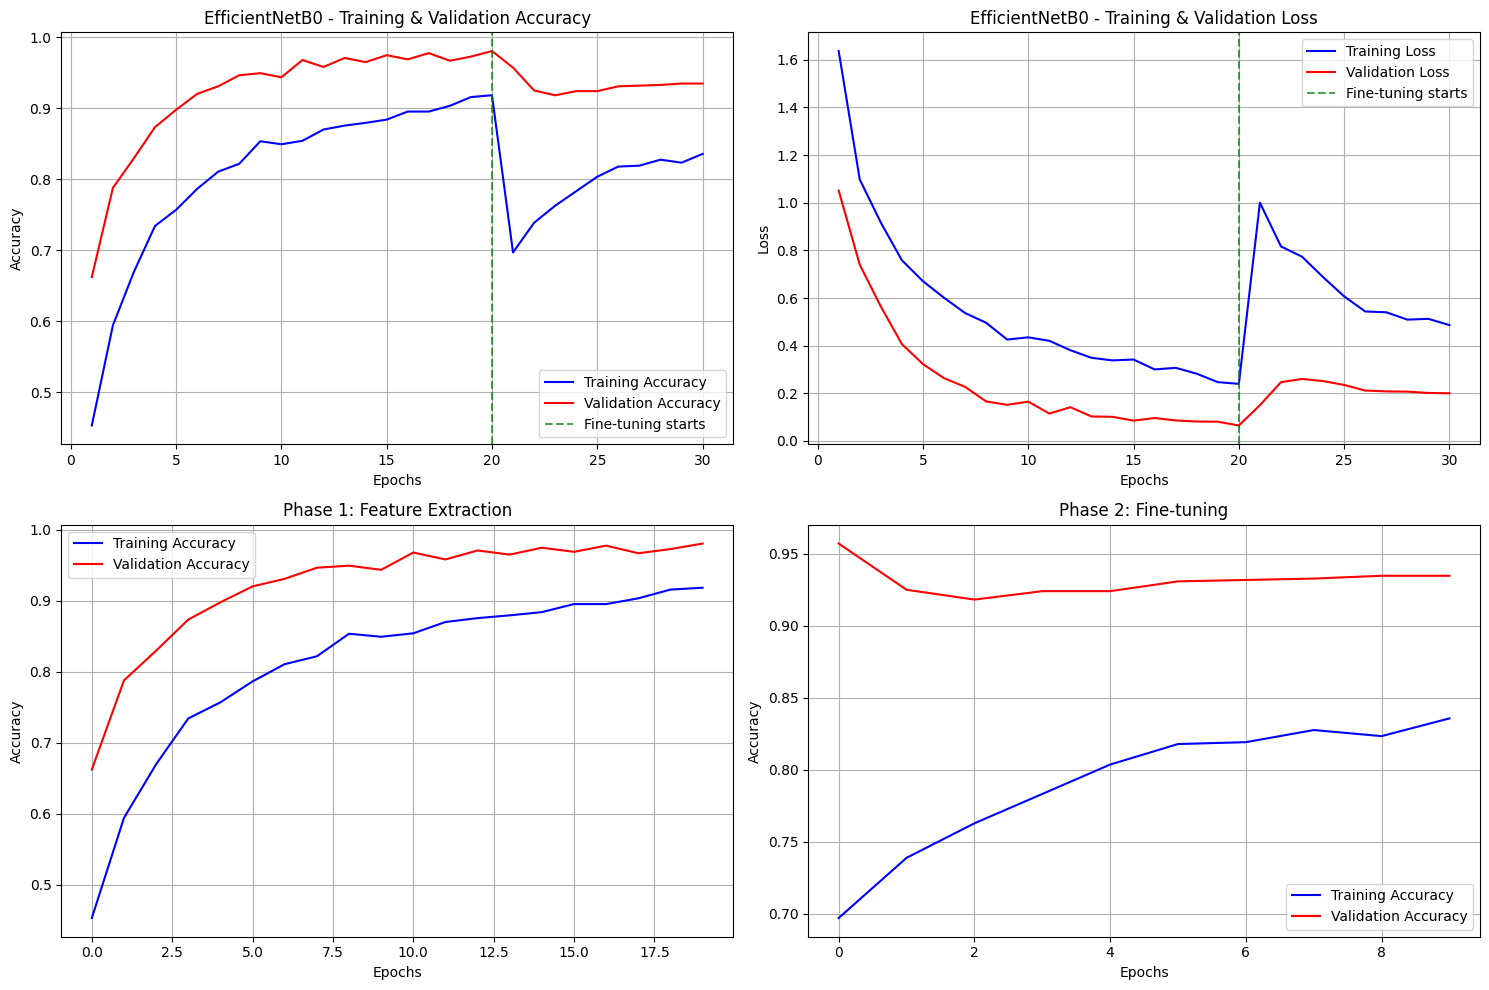


📊 Final Results for EfficientNetB0:
Phase 1 Final Val Accuracy: 0.9805
Phase 2 Final Val Accuracy: 0.9348
🏆 Best Val Accuracy: 0.9805


In [39]:
# Plot training history
plot_transfer_learning_history(history_initial, history_fine_tune, 'EfficientNetB0')

In [40]:
# Save EfficientNetB0 model
efficientnet_save_path = '/content/drive/MyDrive/Models/Teeth Classification/efficientnetb0_transfer_final.keras'
efficientnet_model.save(efficientnet_save_path)
print(f"✅ EfficientNetB0 model saved to: {efficientnet_save_path}")

✅ EfficientNetB0 model saved to: /content/drive/MyDrive/Models/Teeth Classification/efficientnetb0_transfer_final.keras


---

## 9. Final Results Comparison

In [49]:
# Compile all results
results = {
    'ResNet50': {
        'model': resnet_model,
        'test_accuracy': resnet_accuracy,
        'params': resnet_model.count_params()
    },
    'EfficientNetB0': {
        'model': efficientnet_model,
        'test_accuracy': efficientnet_accuracy,
        'params': efficientnet_model.count_params()
    }
}

In [50]:
# Display comparison
print("\n" + "="*70)
print("🏆 FINAL COMPARISON OF ALL MODELS")
print("="*70)
print(f"{'Model':<15} | {'Test Accuracy':<15} | {'Parameters':<15}")
print("-" * 70)

for name, result in results.items():
    print(f"{name:<15} | {result['test_accuracy']:<15.4f} | {result['params']:<15,}")


🏆 FINAL COMPARISON OF ALL MODELS
Model           | Test Accuracy   | Parameters     
----------------------------------------------------------------------
ResNet50        | 0.9874          | 24,154,759     
EfficientNetB0  | 0.9533          | 4,416,938      


In [ ]:
# Find best model

best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
best_accuracy = results[best_model_name]['test_accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"🎯 Best Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"🚀 Model Parameters: {results[best_model_name]['params']:,}")


🏆 BEST MODEL: ResNet50
🎯 Best Test Accuracy: 0.9874 (98.74%)
🚀 Model Parameters: 24,154,759
